In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import six
project_path = os.getcwd() + '/../'
sys.path.append(project_path + "utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

import function
import preprocessing
import local_bayes
import visualize
import metrics

In [3]:
sys.path.append(project_path + "models/cnn")
import cnn

# data load

In [4]:
import data

In [5]:
with open('../data/mnist/mnist.pkl', 'rb') as mnist_pickle:
        mnist = six.moves.cPickle.load(mnist_pickle)
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32)

N = 60000
train_x, test_x = np.split(mnist['data'],   [N])
train_y, test_y = np.split(mnist['target'], [N])

# nearest points

In [6]:
nn_num=100 ## 適当
data_dim=train_x.shape[1]
max_dist=0

In [7]:
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist)

In [9]:
# nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, test_x[0])

## prediction

## logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import collections

In [17]:
# all([nn_label_array[0] == label for label in nn_label_array])

In [18]:
# lr_clf = LogisticRegression(C=0.01, penalty='l2')

In [43]:
k = numpy.array([3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 3])
count_dict = collections.Counter(k)
count_dict.most_common(1)[0][0]

3

In [48]:
correct, correct_knn, correct_lr, correct_br, sum = 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, x)
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## kNN
        count_dict = collections.Counter(nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
        print "kNN: %s" % pred_knn
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(nn_train_array, nn_label_array) 
        pred_lr = int(lr.predict(x)[0])
        print "logi: %s" % pred_lr
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian ridge regression
        br = linear_model.BayesianRidge()
        br.fit(nn_train_array, nn_label_array)
        pred_br = int(round(br.predict(x)))
        print "bayesian logi: %s" % pred_br
        
        if pred_br == t:
            correct_br += 1.0
            
    sum += 1.0
    
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
print "bayesian logi result: %s" % ((correct_br + correct) / sum)

iteration: 0
kNN: 2
logi: 2
bayesian logi: 2
iteration: 1
iteration: 2
iteration: 3
kNN: 4
logi: 4
bayesian logi: 4
iteration: 4
iteration: 5
kNN: 4
logi: 4
bayesian logi: 5
iteration: 6
kNN: 9
logi: 9
bayesian logi: 8
iteration: 7
kNN: 5
logi: 5
bayesian logi: 5
iteration: 8
kNN: 9
logi: 9
bayesian logi: 9
iteration: 9
iteration: 10
kNN: 6
logi: 6
bayesian logi: 6
iteration: 11
kNN: 9
logi: 9
bayesian logi: 8
iteration: 12
iteration: 13
iteration: 14
kNN: 5
logi: 5
bayesian logi: 5
iteration: 15
kNN: 9
logi: 9
bayesian logi: 9
iteration: 16
iteration: 17
kNN: 3
logi: 3
bayesian logi: 4
iteration: 18
kNN: 4
logi: 4
bayesian logi: 4
iteration: 19
kNN: 9
logi: 9
bayesian logi: 9
iteration: 20
kNN: 6
logi: 6
bayesian logi: 6
iteration: 21
iteration: 22
kNN: 5
logi: 5
bayesian logi: 5
iteration: 23
kNN: 4
logi: 4
bayesian logi: 5
iteration: 24
iteration: 25
kNN: 7
logi: 7
bayesian logi: 7
iteration: 26
kNN: 4
logi: 4
bayesian logi: 4
iteration: 27
iteration: 28
iteration: 29
iteration: 30


In [12]:
from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]
br = linear_model.BayesianRidge()
br.fit(X, Y)
print br.predict ([1, 0.])

0.500000132713


## 

### CNN

In [15]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [16]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [17]:
sys.path.append(project_path + "models/cnn")
import cnn_net

In [18]:
N_test = numpy.array(nn_ts_ls).shape[0]
data_dim = test_0_0['x'].shape[1]

In [19]:
model = L.Classifier(cnn_net.tsCNN_net(data_dim))

In [20]:
serializers.load_npz(save_model_dir + "mlp.model", model)

In [21]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [22]:
nn_x = numpy.array(nn_ts_ls).reshape((N_test, 1, 1, data_dim))

In [23]:
cnn_pred = []
for i in range(0, N_test):
    x = np.asarray(nn_x[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    
    pred_ = F.softmax(model.predictor(chainer.Variable(x)))
    cnn_pred.append(pred_.data[0][1])

In [24]:
cnn_pred

[0.99998808,
 0.99992847,
 0.99847454,
 0.00068034005,
 0.99983895,
 0.99991691,
 0.99835289,
 0.99988604,
 0.99999654,
 0.99999881,
 1.7782388e-06,
 0.00083333434,
 0.99995387,
 6.9481149e-07,
 0.0016020698,
 0.99998116,
 0.97835082,
 2.3233448e-34,
 2.7620164e-05,
 0.99978036]

## local bayes estimation

In [25]:
localbayes = local_bayes.LocalBayes(nn_num=20, data_dim=30, max_dist=50)

In [26]:
learner_name_ls = ['cnn', 'gbdt']
pred_proba_dict = {}
pred_proba_dict.update({'cnn':cnn_pred})
pred_proba_dict.update({'gbdt':gbdt_pred})

In [27]:
model_dict = {}
model_dict.update({'cnn':model})
model_dict.update({'gbdt':bdt})

In [28]:
len(test_0_0['x'])

2378

In [32]:
train_data_num = 1000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [33]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

2377

In [34]:
train_data_num = 2000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [ ]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

In [110]:
result = numpy.load(save_result_dir + 'result.npz')

In [47]:
result['pred'][:10]

array([  7.44085895e-08,   4.92851874e-01,   5.05491118e-01,
         5.01789553e-01,   5.01838336e-01,   5.01104980e-01,
         9.99994993e-01,   4.75736980e-01,   5.01543764e-01,
         4.60059043e-01])

In [46]:
w_dict_ls

[{'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt'

In [39]:
visual = visualize.Visualize()

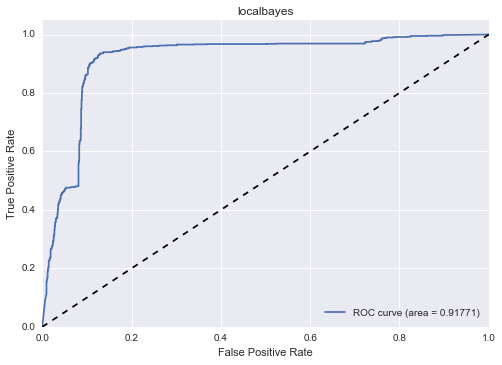

In [42]:
visual.roc_curve('localbayes', test_0_0, result['pred'])